#### Getting Started with BinsceneA

This notebook shows how to load the BinsceneA dataset in PyTorch, what kind of samples it contains and how they can be visualized and transformed.

In [1]:
import random
import matplotlib.pyplot as plt
from dataset_util.dataset import BinsceneA
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# create an instance of the BinsceneA dataset
binscene_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='full', premultiply_alpha=True)
# display some information on the dataset
print(f'The dataset contains {len(binscene_dataset)} samples.')
print(f'It contains objects from the following {len(binscene_dataset.class_labels)} classes:')
print(binscene_dataset.class_labels, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(binscene_dataset))
# 
img_tensor, object_visibility_vector = binscene_dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(binscene_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)
print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of an object visibility vector is:', object_visibility_vector.shape)

The dataset contains 200000 samples.
It contains objects from the following 17 classes:
['cracker_box' 'sugar_box' 'mustard_bottle' 'potted_meat_can' 'banana'
 'bleach_cleanser' 'mug' 'sponge' 'spatula' 'power_drill' 'wood_block'
 'extra_large_clamp' 'softball' 'golf_ball' 'dice' 'toy_airplane'
 'red_box'] 

The shape of an image tensor is: torch.Size([3, 360, 640])
The shape of an object visibility vector is: torch.Size([17])


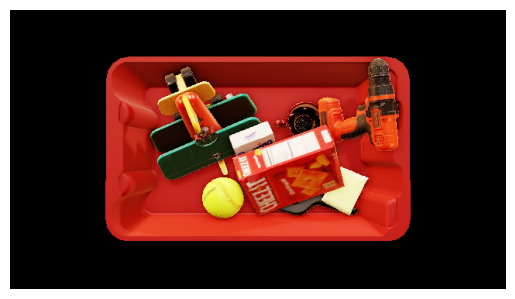

Visible objects are cracker_box, dice, extra_large_clamp, mug, power_drill, red_box, softball, sponge, sugar_box and toy_airplane.


In [3]:
# we can also have the dataset visualize and describe a sample
fig, ax = plt.subplots()
ax, image_description = binscene_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

#### Transforms


Just like any PyTorch [VisionDataset](https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html), the binscene datasets accept custom *transforms*, *transform* and *target_transform*. The cell below illustrates this by resizing the images when they are loaded. For more information about transforming data, see the [PyTorch Docs](https://pytorch.org/vision/main/transforms.html).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(-2.1179) tensor(2.5354)
The shape of the object visibility vector is: torch.Size([17])


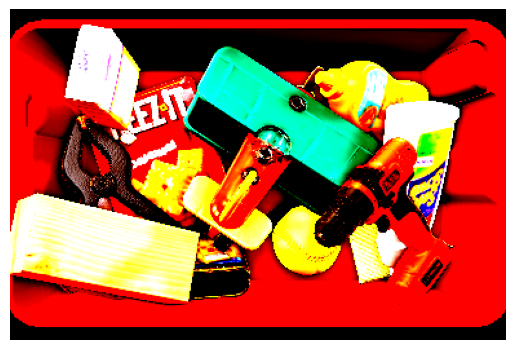

Visible objects are bleach_cleanser, cracker_box, dice, extra_large_clamp, golf_ball, mug, mustard_bottle, potted_meat_can, power_drill, red_box, softball, spatula, sponge, sugar_box, toy_airplane and wood_block.


In [4]:
import torchvision
# we don't need this module to warn us about all kinds of stuff
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize

# transform is applied to the images, target transform is applied to the visibility vectors
# transformS is applied to a tuple of (image, visibility vector)
# These functions can be defined and chained as desired, but they expect torch tensors as inputs

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
image_transform = Compose([resize_transform, crop_transform])
norm_transform = Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
crop_norm_transform = Compose([crop_transform,norm_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='train', premultiply_alpha=True, 
                                transform=crop_norm_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=32,
                                          shuffle=True, num_workers=12,pin_memory=True)
transformed_dataset_eval = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_norm_transform)
evalloader = torch.utils.data.DataLoader(transformed_dataset_eval, batch_size=512,
                                          shuffle=True, num_workers=12,pin_memory=True)

# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

In [5]:
import torchvision.models as models

class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.swin_v2_s(weights=models.Swin_V2_S_Weights.IMAGENET1K_V1)
        resnet.head = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Linear(in_features=768, out_features=n_classes)
        )
        #resnet.requires_grad_(False)
        #resnet.fc.requires_grad_(True)
        self.base_model = resnet
        #self.sigm = nn.Sigmoid()
 
    def forward(self, x):
        return self.base_model(x)
 


In [6]:
learning_rate = 0.002

# Initialize the model
model = Resnext50(17)
criterion1 = nn.MultiLabelSoftMarginLoss()
criterion2 = nn.MultiLabelMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=256, verbose=True)

In [7]:
from tqdm.notebook import tqdm

In [8]:
from torch.nn.utils.rnn import pad_sequence
def onehot2labels(target):
    ret = [torch.zeros_like(target[0])] + [torch.argwhere(row).squeeze(-1) for row in target]
    return pad_sequence(ret, batch_first=True, padding_value=-1).long()[1:]

In [9]:
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

48981515
48981515


In [10]:
#alternative training + evaluation after every epoch
model.to(device)
best_val_loss = 1e25

progress_bar = tqdm(range(3), total=3, position=0, leave=True)
for epoch in progress_bar:
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1}, refresh=True)
        img_tensors, class_labels = [t.to(device) for t in data]
        class_labels = class_labels.float()
        hinge_targets = onehot2labels(class_labels)
        optimizer.zero_grad()
        outputs = model(img_tensors)
        loss_soft = criterion1(outputs,class_labels)
        #print(f'MultiLabelSoftMarginLoss:{loss_soft}')
        loss_no_softie = criterion2(outputs, hinge_targets)
        #print(f'MultiLabelMarginLoss: {loss_no_softie}')
        loss_curr = loss_soft + 0.0*loss_no_softie

        loss_curr.backward()
        optimizer.step()
        #scheduler.step(loss.item())
        
        running_loss += loss_curr.item()
        if i%10==9:
            print(f'[{epoch + 1}, {i + 1:5d}] running_loss: {running_loss / 10:.3f}, best_val_loss: {best_val_loss:.3f}')
            running_loss = 0.0
    # EVALUATION
    model.eval()
    total_loss = 0.0
    sumq = 0.0
    with torch.no_grad():
        for i, data in enumerate(evalloader):
            loss_curr = 0 
            progress_bar.set_postfix({f'V of {[len(evalloader)]}' : i+1}, refresh=True)
            img_tensors, class_labels = [t.to(device) for t in data]
            class_labels = class_labels.float()
            hinge_targets = onehot2labels(class_labels)
            outputs = model(img_tensors)
            pred = (torch.sigmoid(outputs) > 0.3)
            sumq += (pred == class_labels).sum().item() / 17.
            loss = criterion1(outputs,class_labels)
            loss += 0.0*criterion2(outputs, hinge_targets)
            total_loss += loss.item()

    average_loss = total_loss / len(transformed_dataset_eval)
    sumq = sumq / len(transformed_dataset_eval)
    print(f"Evaluation Loss: {average_loss:.4f}, {sumq:.4f}")

    # SAVE BEST MODEL
    if average_loss < best_val_loss:
        best_val_loss = average_loss
        torch.save(model.state_dict(), 'best_model_resNeXt50.pt')
    episode_summary=[f"{epoch+1}:"]+ [f"Best Val Loss:{best_val_loss:.4f}, Curr_Average_loss:{average_loss:.4f}, Curr_Average_Hitrate: {sumq:.4f}"]
    progress_bar.set_description("".join(episode_summary))
    

  0%|          | 0/3 [00:00<?, ?it/s]

[1,    10] running_loss: 0.679, best_val_loss: 10000000000000000905969664.000
[1,    20] running_loss: 0.653, best_val_loss: 10000000000000000905969664.000
[1,    30] running_loss: 0.655, best_val_loss: 10000000000000000905969664.000
[1,    40] running_loss: 0.657, best_val_loss: 10000000000000000905969664.000
[1,    50] running_loss: 0.651, best_val_loss: 10000000000000000905969664.000
[1,    60] running_loss: 0.655, best_val_loss: 10000000000000000905969664.000
[1,    70] running_loss: 0.652, best_val_loss: 10000000000000000905969664.000
[1,    80] running_loss: 0.650, best_val_loss: 10000000000000000905969664.000
[1,    90] running_loss: 0.660, best_val_loss: 10000000000000000905969664.000
[1,   100] running_loss: 0.651, best_val_loss: 10000000000000000905969664.000
[1,   110] running_loss: 0.632, best_val_loss: 10000000000000000905969664.000
[1,   120] running_loss: 0.581, best_val_loss: 10000000000000000905969664.000
[1,   130] running_loss: 0.562, best_val_loss: 10000000000000000

[1,  1070] running_loss: 0.504, best_val_loss: 10000000000000000905969664.000
[1,  1080] running_loss: 0.531, best_val_loss: 10000000000000000905969664.000
[1,  1090] running_loss: 0.527, best_val_loss: 10000000000000000905969664.000
[1,  1100] running_loss: 0.497, best_val_loss: 10000000000000000905969664.000
[1,  1110] running_loss: 0.515, best_val_loss: 10000000000000000905969664.000
[1,  1120] running_loss: 0.508, best_val_loss: 10000000000000000905969664.000
[1,  1130] running_loss: 0.503, best_val_loss: 10000000000000000905969664.000
[1,  1140] running_loss: 0.510, best_val_loss: 10000000000000000905969664.000
[1,  1150] running_loss: 0.528, best_val_loss: 10000000000000000905969664.000
[1,  1160] running_loss: 0.517, best_val_loss: 10000000000000000905969664.000
[1,  1170] running_loss: 0.518, best_val_loss: 10000000000000000905969664.000
[1,  1180] running_loss: 0.520, best_val_loss: 10000000000000000905969664.000
[1,  1190] running_loss: 0.514, best_val_loss: 10000000000000000

[1,  2130] running_loss: 0.519, best_val_loss: 10000000000000000905969664.000
[1,  2140] running_loss: 0.523, best_val_loss: 10000000000000000905969664.000
[1,  2150] running_loss: 0.512, best_val_loss: 10000000000000000905969664.000
[1,  2160] running_loss: 0.533, best_val_loss: 10000000000000000905969664.000
[1,  2170] running_loss: 0.509, best_val_loss: 10000000000000000905969664.000
[1,  2180] running_loss: 0.508, best_val_loss: 10000000000000000905969664.000
[1,  2190] running_loss: 0.498, best_val_loss: 10000000000000000905969664.000
[1,  2200] running_loss: 0.512, best_val_loss: 10000000000000000905969664.000
[1,  2210] running_loss: 0.512, best_val_loss: 10000000000000000905969664.000
[1,  2220] running_loss: 0.519, best_val_loss: 10000000000000000905969664.000
[1,  2230] running_loss: 0.521, best_val_loss: 10000000000000000905969664.000
[1,  2240] running_loss: 0.507, best_val_loss: 10000000000000000905969664.000
[1,  2250] running_loss: 0.508, best_val_loss: 10000000000000000

[1,  3190] running_loss: 0.512, best_val_loss: 10000000000000000905969664.000
[1,  3200] running_loss: 0.516, best_val_loss: 10000000000000000905969664.000
[1,  3210] running_loss: 0.508, best_val_loss: 10000000000000000905969664.000
[1,  3220] running_loss: 0.486, best_val_loss: 10000000000000000905969664.000
[1,  3230] running_loss: 0.519, best_val_loss: 10000000000000000905969664.000
[1,  3240] running_loss: 0.514, best_val_loss: 10000000000000000905969664.000
[1,  3250] running_loss: 0.506, best_val_loss: 10000000000000000905969664.000
[1,  3260] running_loss: 0.509, best_val_loss: 10000000000000000905969664.000
[1,  3270] running_loss: 0.507, best_val_loss: 10000000000000000905969664.000
[1,  3280] running_loss: 0.500, best_val_loss: 10000000000000000905969664.000
[1,  3290] running_loss: 0.511, best_val_loss: 10000000000000000905969664.000
[1,  3300] running_loss: 0.502, best_val_loss: 10000000000000000905969664.000
[1,  3310] running_loss: 0.509, best_val_loss: 10000000000000000

[1,  4250] running_loss: 0.520, best_val_loss: 10000000000000000905969664.000
[1,  4260] running_loss: 0.511, best_val_loss: 10000000000000000905969664.000
[1,  4270] running_loss: 0.522, best_val_loss: 10000000000000000905969664.000
[1,  4280] running_loss: 0.515, best_val_loss: 10000000000000000905969664.000
[1,  4290] running_loss: 0.516, best_val_loss: 10000000000000000905969664.000
[1,  4300] running_loss: 0.509, best_val_loss: 10000000000000000905969664.000
[1,  4310] running_loss: 0.510, best_val_loss: 10000000000000000905969664.000
[1,  4320] running_loss: 0.515, best_val_loss: 10000000000000000905969664.000
[1,  4330] running_loss: 0.513, best_val_loss: 10000000000000000905969664.000
[1,  4340] running_loss: 0.513, best_val_loss: 10000000000000000905969664.000
[1,  4350] running_loss: 0.504, best_val_loss: 10000000000000000905969664.000
[1,  4360] running_loss: 0.522, best_val_loss: 10000000000000000905969664.000
[1,  4370] running_loss: 0.522, best_val_loss: 10000000000000000

[2,   440] running_loss: 0.509, best_val_loss: 0.001
[2,   450] running_loss: 0.512, best_val_loss: 0.001
[2,   460] running_loss: 0.501, best_val_loss: 0.001
[2,   470] running_loss: 0.514, best_val_loss: 0.001
[2,   480] running_loss: 0.498, best_val_loss: 0.001
[2,   490] running_loss: 0.509, best_val_loss: 0.001
[2,   500] running_loss: 0.510, best_val_loss: 0.001
[2,   510] running_loss: 0.504, best_val_loss: 0.001
[2,   520] running_loss: 0.476, best_val_loss: 0.001
[2,   530] running_loss: 0.505, best_val_loss: 0.001
[2,   540] running_loss: 0.517, best_val_loss: 0.001
[2,   550] running_loss: 0.513, best_val_loss: 0.001
[2,   560] running_loss: 0.507, best_val_loss: 0.001
[2,   570] running_loss: 0.519, best_val_loss: 0.001
[2,   580] running_loss: 0.508, best_val_loss: 0.001
[2,   590] running_loss: 0.509, best_val_loss: 0.001
[2,   600] running_loss: 0.505, best_val_loss: 0.001
[2,   610] running_loss: 0.511, best_val_loss: 0.001
[2,   620] running_loss: 0.509, best_val_loss:

[2,  1990] running_loss: 0.513, best_val_loss: 0.001
[2,  2000] running_loss: 0.500, best_val_loss: 0.001
[2,  2010] running_loss: 0.502, best_val_loss: 0.001
[2,  2020] running_loss: 0.494, best_val_loss: 0.001
[2,  2030] running_loss: 0.499, best_val_loss: 0.001
[2,  2040] running_loss: 0.508, best_val_loss: 0.001
[2,  2050] running_loss: 0.502, best_val_loss: 0.001
[2,  2060] running_loss: 0.498, best_val_loss: 0.001
[2,  2070] running_loss: 0.506, best_val_loss: 0.001
[2,  2080] running_loss: 0.497, best_val_loss: 0.001
[2,  2090] running_loss: 0.519, best_val_loss: 0.001
[2,  2100] running_loss: 0.512, best_val_loss: 0.001
[2,  2110] running_loss: 0.509, best_val_loss: 0.001
[2,  2120] running_loss: 0.509, best_val_loss: 0.001
[2,  2130] running_loss: 0.511, best_val_loss: 0.001
[2,  2140] running_loss: 0.495, best_val_loss: 0.001
[2,  2150] running_loss: 0.497, best_val_loss: 0.001
[2,  2160] running_loss: 0.502, best_val_loss: 0.001
[2,  2170] running_loss: 0.510, best_val_loss:

[2,  3540] running_loss: 0.538, best_val_loss: 0.001
[2,  3550] running_loss: 0.522, best_val_loss: 0.001
[2,  3560] running_loss: 0.535, best_val_loss: 0.001
[2,  3570] running_loss: 0.515, best_val_loss: 0.001
[2,  3580] running_loss: 0.538, best_val_loss: 0.001
[2,  3590] running_loss: 0.524, best_val_loss: 0.001
[2,  3600] running_loss: 0.534, best_val_loss: 0.001
[2,  3610] running_loss: 0.530, best_val_loss: 0.001
[2,  3620] running_loss: 0.521, best_val_loss: 0.001
[2,  3630] running_loss: 0.523, best_val_loss: 0.001
[2,  3640] running_loss: 0.516, best_val_loss: 0.001
[2,  3650] running_loss: 0.509, best_val_loss: 0.001
[2,  3660] running_loss: 0.531, best_val_loss: 0.001
[2,  3670] running_loss: 0.518, best_val_loss: 0.001
[2,  3680] running_loss: 0.507, best_val_loss: 0.001
[2,  3690] running_loss: 0.518, best_val_loss: 0.001
[2,  3700] running_loss: 0.536, best_val_loss: 0.001
[2,  3710] running_loss: 0.509, best_val_loss: 0.001
[2,  3720] running_loss: 0.531, best_val_loss:

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.50 GiB (GPU 0; 23.65 GiB total capacity; 8.06 GiB already allocated; 3.41 GiB free; 18.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(class_labels.shape)
tmp = onehot2labels(class_labels)
print(tmp.shape)
#tmp2 = [torch.zeros_like(class_labels[0])] + [torch.argwhere(row == 1) for row in class_labels]
#print(tmp2)
#tmp3 = [torch.argwhere(row).squeeze(-1) for row in class_labels]
#tmp3 = pad_sequence(tmp3, batch_first=True, padding_value=-1)
#print(tmp3.shape)
print(class_labels[0])
print(tmp[0])

In [ ]:
from torchvision import transforms

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
#resize_transform = Resize(size=(90, 160), antialias=True)
#crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
#image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset_valid = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_norm_transform)


mean_imagenet, std_imagenet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean_imagenet, std_imagenet)],
   std= [1/s for s in std_imagenet]
)

#trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128,
#                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset_valid))
img_tensor, object_visibility_vector = transformed_dataset_valid.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape, object_visibility_vector.type())
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset_valid.show(inv_normalize(img_tensor), object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

#print(object_visibility_vector.shape)
model.eval()
with torch.no_grad():
    out = model(img_tensor.unsqueeze(0).to(device)).cpu().squeeze(0)
    out = torch.sigmoid(out)
    pred = (out > 0.6) #.int()

    
print(object_visibility_vector)
print(pred)
print(object_visibility_vector == pred, (object_visibility_vector == pred).sum()/17.)

fig, ax = plt.subplots()
ax, image_description_prediction = transformed_dataset_valid.show(inv_normalize(img_tensor), pred, ax)
plt.axis('off')
plt.show()
print('Model output')
print(image_description_prediction)

In [ ]:
plt.hist(out.cpu().numpy())
plt.show()